# Synthetic experiments 

Using synthetic DGPs for DRCT, we produce DOBS using Algorithm 2 from Gentzel et al. (2021) and
separately via our RCT rejection sampler.

In [1]:
from causal_eval.sampling import *

import seaborn as sns
import matplotlib.pyplot as plt

%load_ext autoreload
%autoreload 2 

In [2]:
# random seed for the sampling methods same throughout
rng = np.random.default_rng(10)

### Synthetic DGP Setting #1 
`|C| = 1, P (T = 1) = 0.3`

In [7]:
data, rct_ace = synthetic_dgp(setting=1, num_samples=100000)

Sanity check
RCT ACE unadjusted:  2.4809951502961516
RCT ACE adjusting for C parametric backdoor:  2.4864917936261794


In [8]:
# Use the same parameters for the researcher-specified confouding functions for both sampling approaches
confound_func_params={"para_form": "linear"} 

In the cell below, we calculate the absolute bias (abs. bias) between ATE from DRCT and the estimated ATE via backdoor adjustment on DOBS created by each sampling algorithm. We also report abs. bias relative to the RCT ATE
(rel. abs. bias) and the mean and standard deviation (std.) across samples from 1000 random seeds.

#### Confidence Intervals 

We can construct confidence intervals via bootstrapping. We follow these steps: 

1. Use sampling (RCT rejection or Gentzel) to create data sample $S$
2. Bootstrapping: resample $S$ with replacement $b$ times. 
3. Calculate the ACE for each bootstrap sample. 
4. Use the percentile method to obtain 95% confidence intervals. 

In [9]:
data_out1 = bootstrapping_three_methods_linear(data, rct_ace, confound_func_params)

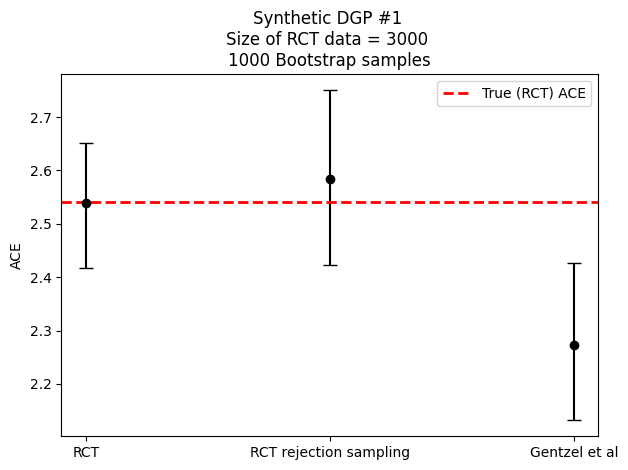

In [6]:
title = f"Synthetic DGP #1 \nSize of RCT data = {len(data)} \n1000 Bootstrap samples"
plot_bootstrap(data_out1, rct_ace, title);

We'll do the same thing with a smaller number of original samples. 

In [ ]:
data, rct_ace = synthetic_dgp(setting=1, num_samples=3000)

In [ ]:
data_out2 = bootstrapping_three_methods_linear(data, rct_ace, confound_func_params)

In [ ]:
title = f"Synthetic DGP #1 \nSize of RCT data = {len(data)} \n1000 Bootstrap samples"
plot_bootstrap(data_out2, rct_ace, title);

Now, run through many seeds and get the results for the table. 

In [10]:
data, rct_ace = synthetic_dgp(setting=1, num_samples=100000)

Sanity check
RCT ACE unadjusted:  2.4809951502961516
RCT ACE adjusting for C parametric backdoor:  2.4864917936261794


In [12]:
out =  many_seeds(data, rct_ace, confound_func_params, is_linear=True, num_seeds=2, 
                  has_bootstrap=True, 
                  num_bootstrap_samples=1000)

Invalid sample, T*C==T for all units
OBRCT num invalid samples= 1
Rejection num invalid samples= 1

OBSRCT: MAE (over2 random seeds)=  0.21941804008929422
	OBSRCT: std AE (over2 random seeds)=  0.0
OBSRCT: Relative MAE (over2 random seeds)=  0.08843952801080757
	OBSRCT: Relative AE std (over2 random seeds)=  0.0

Rejection: MAE (over 2 random seeds)=  0.003755832345401
	Rejection: std AE (over 2 random seeds)=  0.0
Rejection: Relative MAE (over2 random seeds)=  0.0015138410669414946
	Rejection: Relative AE std (over2 random seeds)=  0.0

=== CI Coverage === 
Num bootstrap samples=1000
OSRCT CI Coverage:  0.0
Rejection CI Coverage: 1.0


### Synthetic DGP Setting #2 
`|C| = 1, P (T = 1) = 0.5 `

In [ ]:
data, rct_ace = synthetic_dgp(setting=2, num_samples=100000)

The cell below gives the results for the two different sampling algorithms for the synthetic DGP setting in the cell above across 1000 random seeds. 

In [ ]:
confound_func_params={"para_form": "linear"} 
out =  many_seeds(data, rct_ace, confound_func_params, is_linear=True, num_seeds=1000, 
                  has_bootstrap=True, 
                  num_bootstrap_samples=1000)

### Synthetic DGP Setting #3 
`|C| = 5, Nonlinear`

In [ ]:
data, rct_ace = synthetic_dgp(setting=3, num_samples=100000)

The cell below gives the results for the two different sampling algorithms for the synthetic DGP setting in the cell above across 1000 random seeds. 

In [ ]:
confound_func_params = {"para_form": "nonlinear", "C1": 1.5, "C2": -0.7, "C3": 1.2, "C4": 1.5, "C5": -1.2}

out =  many_seeds(data, rct_ace, confound_func_params, 
                  is_linear=False, 
                  num_seeds=1000, 
                  has_bootstrap=True, 
                  num_bootstrap_samples=1000)